# Scanning Whiteboard Contents

## Final Project of Digital Image Processing course [SCC0251]

This notebook contains the final report of an application developed as the final project of the Digital Image Processing course(SCC0251) at the Institute of Mathematics and Computer Science(ICMC-USP) by Prof. Moacir Ponti.

### Students
- David Souza Rodrigues;
- Marcos Wendell Souza de Oliveira Santos;

### Objective
The goal of this application is the digitalization of whiteboard contents capture. This application locates the boundary of the whiteboard, rectifies the geometry distortion and corrects the non-uniform illumination.

### Application Functionalities
The application will read a whiteboard image, remove its surroundings, centralize the whiteboard content and adjust image luminosity as to facilitate the comprehension of the image.

### Images Source
The application will be developed based on the images available on the Pantheon Project website, plus images captured by the students using black, blue, red and green markers while using flash on the camera.

### Digital Images Processing Techniques
1. Edges' detection: Using the differential filter with a convolution operation;
2. Horizontal and Vertical lines' detection: A convolution with the proper filters may be used, as well as the Hough transform;
3. Whiteboard's boundaries detection: Given the detected lines, identify the best possible match for the quadrilateral shape of the whitedoard's boundaries;
4. Image's Geometry correction: Perform a 3D transformation to adjust the coordinates;
5. Luminosity correction: Color enhancement to obtain a uniform background, removing light spots.

In this application we will be using:
- _numpy_ library to manipulate and compute with high-performance multidimensional arrays;
- _imageio_ to read the input image;
- _pyplot_ to show the images generated in each step of the program;
- _scipy_ to apply the convolution operations;
- _math_ for mathematical operations;
- _cv2_ to find the quadragular region of the whiteboard and apply the homography method;

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as iio
from scipy.signal import convolve
from math import *
import cv2

First of all, we start by reading the input image located in a specif file.

File location:


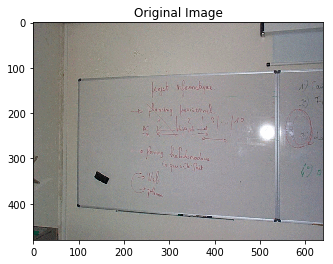

In [2]:
image = iio.imread("./images/whiteboard01.png")
plt.imshow(image)
plt.title("Original Image")
plt.show()

Then, a luminance operation is applied so we can obtain a gray-level image as result.

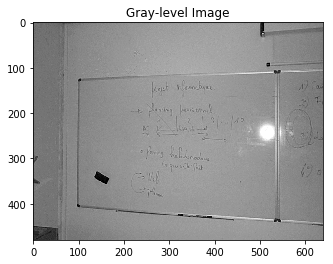

In [3]:
image1 = 0.299*image[:,:,0]+0.587*image[:,:,1]+0.114*image[:,:,2]
plt.imshow(image1, cmap="gray")
plt.title("Gray-level Image")
plt.show()

Soon after, we generate and apply a Gaussian Filter to reduce the gray-level image noise.

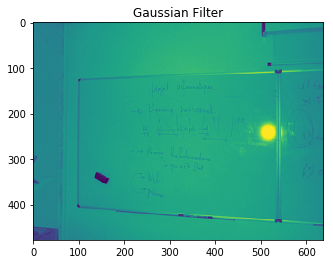

In [4]:
k, sigma = 3, 1.0
arx = np.arange((-k//2)+1.0,(k//2)+1.0)
x,y = np.meshgrid(arx,arx)
filt = np.exp(-(1/2)*(np.square(x)+np.square(y))/np.square(sigma))
gaussian_filter = filt/np.sum(filt)
image2 = convolve(image1,gaussian_filter,'valid')
plt.imshow(image2)
plt.title("Gaussian Filter")
plt.show()

Afterwards, in order to find the edges of the objects on the image scene, we apply an horizontal and a vertical mask based on Sobel's filter, a discrete differentiation operator that compute an approximation of the gradient of the image intensity function.

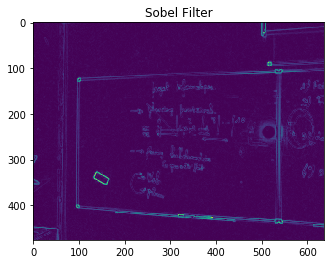

In [5]:
vertical = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
horizontal = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
image3 = np.absolute(convolve(image2,vertical,'valid')) + np.absolute(convolve(image2,horizontal,'valid'))
plt.imshow(image3)
plt.title("Sobel Filter")
plt.show()

Then, we normalize the image in range [0,255] so that we can compare with a threshold later. 

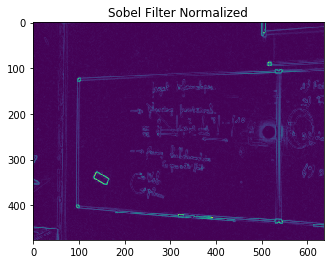

In [6]:
newMax = 255
max, min = image3.max(), image3.min()
image3 = newMax*((image3-min)/(max-min))
plt.imshow(image3)
plt.title("Sobel Filter Normalized")
plt.show()

The threshold chosen by this application was determined only by the analysis of the normalized image obtained in the previous step and may vary according to the input image. 

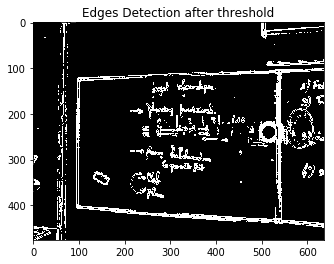

In [16]:
tH = 15
image4 = np.where(image3 >= tH, 1,0)
plt.imshow(image4, cmap="gray")
plt.title("Edges Detection after threshold")
plt.show()

Now, let's define some functions to deal with the line's detection, in this case, we'll be using the Hough Transform technique to find the most outstanding lines(in our case, 5 lines). This technique's purpose is to find imperfect instances of objects within a certain class of shapes by a voting procedure. This voting procedure is carried out in a parameter space, from which object candidates are obtained as local maximum value in a so-called accumulator space that is explicitly constructed by the algorithm for computing the Hough Transform.

A line can be represented as _y = mx+c_ or in parametric form, as _rho = x * cos(theta) + y * sin(theta)_, where rho is the perpendicular distance from origin to the line, and theta is the angle formed by this perpendicular line and horizontal axis measured in counter-clockwise.

Hough Transform will use the _(rho,theta)_ space as parameter space so for each feature point in the image, put a vote in every element in this space that could have generated this point.

In [8]:
def HoughTransform(img,minAngle=-90.0,maxAngle=90.0):
    M,N =  img.shape
    dist_max = ceil(sqrt(M*M+N*N))
    theta = np.deg2rad(np.arange(minAngle,maxAngle))
    # dists = np.linspace(-dist_max,dist_max,dist_max*2)
    hough = np.zeros((dist_max*2,len(theta)))
    x,y = np.nonzero(img)
    points = [[list()] * len(theta) for i in range(dist_max*2)]
    newImage = np.zeros((img.shape))

    c = np.cos(theta)
    s = np.sin(theta)
    aa = dist_max*2
    for i in range(len(x)):
        xa = x[i]
        ya = y[i]
        for t in range(len(theta)):
            rho = int(round(xa*c[t] + ya*s[t]))+dist_max
            if(rho < aa):
                hough[rho,t] += 1
                points[rho][t].append((xa,ya))
    max = maxPoints(hough)
    for x in range(dist_max*2):
        for y in range(len(theta)):
            if(hough[x][y] in max):
                for z in points[x][y]:
                    newImage[z[0]][z[1]] = 255
    return newImage

def maxPoints(hough, n=5):
    flat = hough.flatten()
    flat = np.flip(np.sort(flat))

    max = []
    for i in range(n):
        max.append(flat[0])
        idx = np.argwhere(flat==flat[0])
        flat = np.delete(flat, idx)

    return max

We're going to apply the Hough Transform to the vertical lines, that is, 90 degrees, with a tolerance of 20 degrees upwards and downwards to compensate the angle's variation on the image.

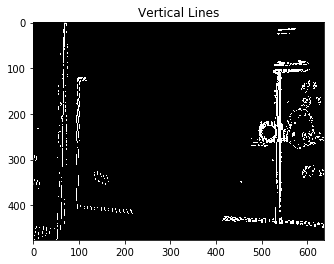

In [17]:
image5 = HoughTransform(image4,70.0,110.0)
plt.imshow(image5, cmap="gray")
plt.title("Vertical Lines")
plt.show()

Then, apply it to the horizontal lines, that is, 0 degrees, with a tolerance of 20 degrees upwards and downwards as well.

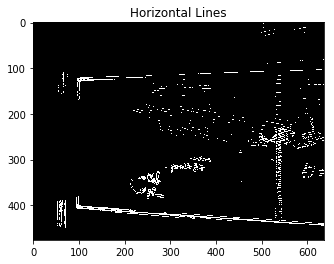

In [18]:
image6 = HoughTransform(image4,-20.0,20.0)
plt.imshow(image6, cmap="gray")
plt.title("Horizontal Lines")
plt.show()

Finally, we join the results of both function calls in a single image and will obtain the 10 most outstanding vertical and horizontal lines highlighted.

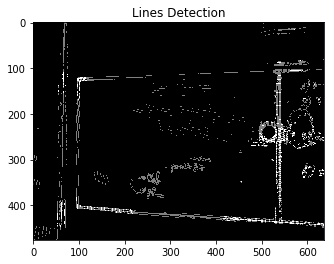

In [20]:
image7 = image5 + image6
plt.imshow(image7, cmap="gray")
plt.title("Lines Detection")
plt.show()

The next step in our application would have consisted in finding the whiteboard's vertices, but we didn't have sufficient time or knowledge to figure out how to do it in a proper way. 

We began to code a solution for it based in an openCV library function called _findContours_, but the Hough Transform output image wasn't good enough for obtain the right vertices of the image's shapes, so we prefered to skip to the next step.

In [12]:
image8 = np.where(image7 > 0, 1, 0).astype('uint8')
contours, hierarchy = cv2.findContours(image8, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

With the set of vertices identified, we can apply a homography operation to perform a geometry correction on the image. For this step, we're also using an implemented fuction found on openCV library.

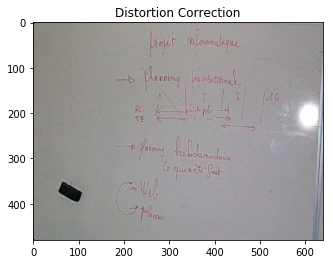

In [13]:
M,N,_ = image.shape
aux,b = cv2.findHomography(np.array(((102,128),(532,110),(553,428),(100,404))),np.array(((0,0),(N,0),(N,M),(0,M))))
image9 = cv2.warpPerspective(image,aux,(N,M))
plt.imshow(image9)
plt.title("Distortion Correction")
plt.show()

The final step in our application consists in a illumination correction on the image.

For this, we are using a convertion to the HSL color space, due to it's specific lightness channel, which makes it easier to handle the analysis and modifications on the illumination aspects of our image.

The ideia here is to find the pixels with high level in the lightness channel and replace them with the mean of the background lightness values, so it gets blended with the image.

In [14]:
newMax = 1
max, min = image9.max(), image9.min()
img = newMax*((image9-min)/(max-min))
hsl = np.ndarray(image9.shape)
image10 = np.ndarray(image9.shape)

for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        #H
        max = img[x][y].argmax()
        min = img[x][y].argmin()
        aux = img[x][y][max] - img[x][y][min]
        if aux == 0:
            hsl[x][y][0] = 0
        elif max == 0:
            hsl[x][y][0] = 60 *((img[x][y][1] - img[x][y][2])/aux)
        elif max == 1:
            hsl[x][y][0] = 60 *(2+((img[x][y][2] - img[x][y][0])/aux))
        elif max == 2:
            hsl[x][y][0] = 60 *(4+((img[x][y][0] - img[x][y][1])/aux))
        if hsl[x][y][0] < 0:
            hsl[x][y][0] += 360

        # L
        hsl[x][y][2] = (img[x][y][max]+img[x][y][min])/2

        # S
        if img[x][y][max] == 0 or img[x][y][min] == 1:
            hsl[x][y][1] = 0
        else:
            hsl[x][y][1] = (2*img[x][y][max]-2*hsl[x][y][2])/(1-abs(2*hsl[x][y][2] - 1))

mean = np.mean(hsl[:,:,2])
background = np.where(hsl[:,:,2] < 0.68,hsl[:,:,2],mean)
newMax = 1
max, min = background.max(), background.min()
hsl[:,:,2] = newMax*((background-min)/(max-min))

Ultimatly, we just need to convert the image back to the RGB color space to obtain our result image.

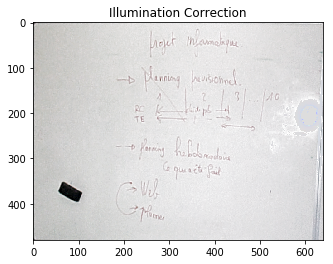

In [15]:
for x in range(img.shape[0]):
    for y in range(img.shape[1]):
        C = (1 - abs(2*hsl[x][y][2] - 1))*hsl[x][y][1]
        H_ = hsl[x][y][0]/60
        X = C*(1 - abs(H_ % 2 - 1))
        m = hsl[x][y][2] - C/2
        if 0 <= H_ and H_ <= 1:
            image10[x][y] = np.array([C,X,0]) + m
        elif 1 < H_ and H_ <= 2:
            image10[x][y] = np.array([X,C,0]) + m
        elif 2 < H_ and H_ <= 3:
            image10[x][y] = np.array([0,C,X]) + m
        elif 3 < H_ and H_ <= 4:
            image10[x][y] = np.array([0,X,C]) + m
        elif 4 < H_ and H_ <= 5:
            image10[x][y] = np.array([X,0,C]) + m
        elif 5 < H_ and H_ <= 6:
            image10[x][y] = np.array([C,0,X]) + m
plt.imshow(image10)
plt.title("Illumination Correction")
plt.show()

As we can see, the flashlight spot has decreased its light level, however we still have some residual high level lightness values on the region' surroundings that we couldn't remove without affecting the image content.